In [2]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from taln.taln_aln import align_ng, tokenize

DATA_DIR = (Path("..").resolve() / "data")

CONTIG_NALN_PATH = DATA_DIR / "boat_contiguous.naln.json"
NONCONTIG_NALN_PATH = DATA_DIR / "boat_noncontiguous.naln.json"

In [3]:
with open(CONTIG_NALN_PATH, "r", encoding="utf-8") as f:
    contig_naln = pd.DataFrame(json.load(f))

with open(NONCONTIG_NALN_PATH, "r", encoding="utf-8") as f:
    noncontig_naln = pd.DataFrame(json.load(f))

contig_naln.shape, noncontig_naln.shape

((159, 4), (198, 6))

In [4]:
contig_naln.head(3)

,pair_id,source,target,idx_start
0,01ebc6ccacee,"Monotheists hold that there is only one god, a...","""oneness"" or ""uniqueness""",[499]
1,05a940ffe9b3,State law codifies Oklahoma's state emblems an...,"no ""official"" vote regarding ""Labor Omnia Vin...",[505]
2,069bf95d2f1c,The band's sixth studio album News of the Worl...,"""We Will Rock You"" and the rock ballad ""We Ar...",[263]


In [5]:
noncontig_naln.head(3)

,pair_id,source,target,idx_start,ablate_target,ablate_idx
0,01ebc6ccacee,"Monotheists hold that there is only one god, a...","""oneness"" or ""uniqueness""",[499],"""oneness"" or ""iqueness""",6
1,05a940ffe9b3,State law codifies Oklahoma's state emblems an...,"no ""official"" vote regarding ""Labor Omnia Vin...",[505],"no """" vote regarding ""Labor Omnia Vincit""",2
2,069bf95d2f1c,The band's sixth studio album News of the Worl...,"""We Will Rock You"" and the rock ballad ""We Ar...",[263],""" Will Rock You"" and the rock ballad ""We Are ...",1


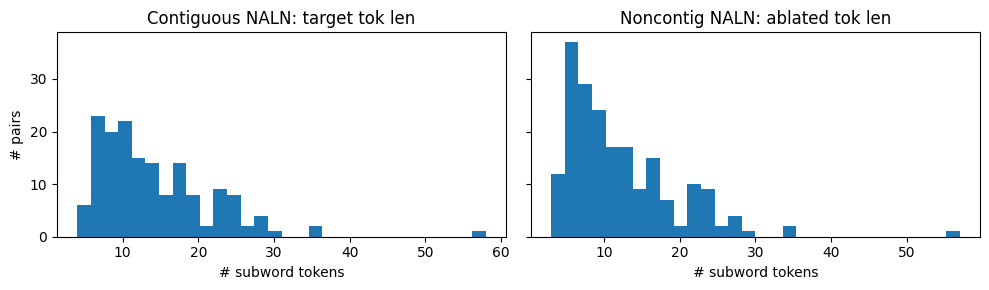

In [6]:
def tok_len(text, ttype="token"):
    toks, _ = tokenize(text, ttype)
    return len(toks)

contig_naln["target_tok_len"] = contig_naln["target"].apply(tok_len)
noncontig_naln["target_tok_len"] = noncontig_naln["target"].apply(tok_len)
noncontig_naln["ablate_tok_len"] = noncontig_naln["ablate_target"].apply(tok_len)

fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
ax[0].hist(contig_naln["target_tok_len"], bins=30)
ax[0].set(title="Contiguous NALN: target tok len", xlabel="# subword tokens", ylabel="# pairs")
ax[1].hist(noncontig_naln["ablate_tok_len"], bins=30)
ax[1].set(title="Noncontig NALN: ablated tok len", xlabel="# subword tokens")
plt.tight_layout()
plt.show()

In [7]:
def tokens_for_debug(text, ttype="token"):
    toks, _ = tokenize(text, ttype)
    return [t["token"] for t in toks]


def source_tokens_in_window(source, lo, hi, ttype="token"):
    toks, _ = tokenize(source, ttype)

    if toks and "start_idx" in toks[0] and "end_idx" in toks[0]:
        return [t["token"] for t in toks if t["start_idx"] < hi and t["end_idx"] > lo]

    # fallback: no character offsets available
    snippet = source[lo:hi]
    return tokens_for_debug(snippet, ttype)


def span_snippet(source, start, target, min_pad=30, max_pad=80):
    pad = max(min_pad, min(max_pad, len(target)))
    lo = max(0, int(start) - pad)
    hi = min(len(source), int(start) + len(target) + pad)
    snippet = source[lo:hi]
    caret = " " * (int(start) - lo) + "^"
    return lo, hi, snippet, caret


# inspect a specific failure (change idx as needed)
idx = 1
r = contig_naln.iloc[idx]

src = r["source"]
tgt = r["target"]
starts = r.get("idx_start") or []

print("pair_id:", r.get("pair_id"))
print("idx_start:", starts)
print("target:", tgt)

for s in starts:
    lo, hi, snippet, caret = span_snippet(src, s, tgt)
    match = src[int(s) : int(s) + len(tgt)] == tgt
    print(f"\n--- source[{lo}:{hi}] around idx_start={s} (match={match}) ---")
    print(snippet)
    print(caret)
    print("\nsource tokens (window):", source_tokens_in_window(src, lo, hi, "token"))

print("\nalign_ng token:", len(align_ng(src, tgt, "token")))
print("align_ng whitespace:", len(align_ng(src, tgt, "whitespace")))

print("\ntarget tokens:", tokens_for_debug(tgt, "token"))

pair_id: 05a940ffe9b3
idx_start: [505]
target:  no "official" vote regarding "Labor Omnia Vincit"

--- source[455:605] around idx_start=505 (match=True) ---
ent researched the Oklahoma Constitution and found no "official" vote regarding "Labor Omnia Vincit", therefore opening the door for an entirely new m
                                                  ^

source tokens (window): [' constituent', ' researched', ' the', ' Oklahoma', ' Constitution', ' and', ' found', ' no', ' "', 'official', '"', ' vote', ' regarding', ' "', 'Labor', ' Om', 'nia', ' V', 'inc', 'it', '",', ' therefore', ' opening', ' the', ' door', ' for', ' an', ' entirely', ' new', ' motto']

align_ng token: 0
align_ng whitespace: 0

target tokens: [' no', ' "', 'official', '"', ' vote', ' regarding', ' "', 'Labor', ' Om', 'nia', ' V', 'inc', 'it', '"']
